## 1. Загрузка и визуализация данных

In [1]:
import os
import torch
import torchvision
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import time
import matplotlib.pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
train_data = torchvision.datasets.CIFAR10(
    download=True,
    root='\\data\\CIFAR10',
    transform=torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.4914, 0.4822, 0.4465),
                                         (0.2023, 0.1994, 0.2010)),]),
    train=True,
)

test_data = torchvision.datasets.CIFAR10(
    download=True,
    root='\\data\\CIFAR10',
    transform=torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.4914, 0.4822, 0.4465),
                                         (0.2023, 0.1994, 0.2010)),
    ]),
    train=False,
)

train_data.data.shape, len(train_data.targets)

Files already downloaded and verified
Files already downloaded and verified


((50000, 32, 32, 3), 50000)

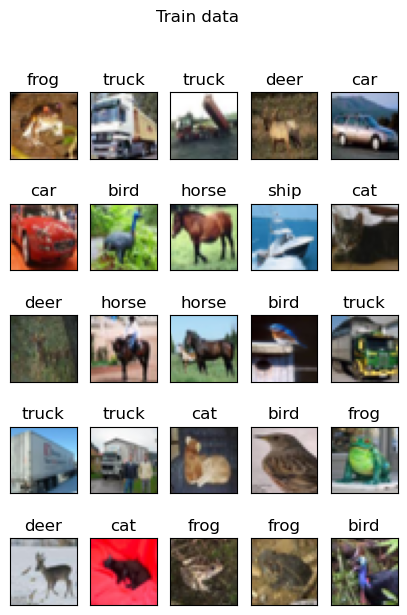

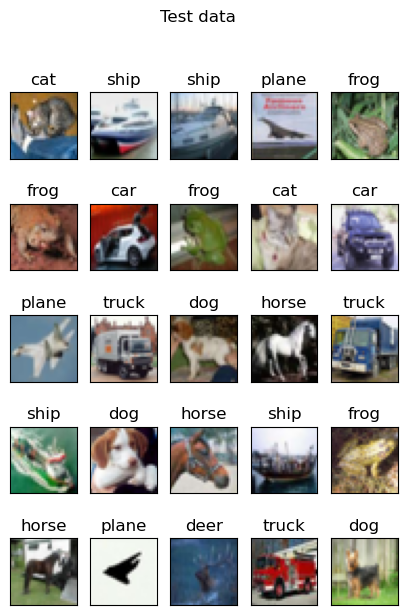

In [3]:
classes = list(('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'))

def show_img(images, labels, rows, cols, title):
    fig, ax = plt.subplots(rows, cols, figsize=(5,7))
    fig.suptitle(title)
    plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])
    for i, ax in enumerate(fig.axes):
        ax.imshow(images[i])
        ax.set_title(classes[labels[i]])

show_img(train_data.data, train_data.targets, 5, 5, title="Train data")
show_img(test_data.data, test_data.targets, 5, 5, title="Test data")

## 2. Создание модели

In [4]:
batch_size = 128

train_data_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_data_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [5]:
class BasicBlock(torch.nn.Module):
    def __init__(self, inPlanes, planes, stride=1):
        super().__init__()

        self.conv1 = torch.nn.Conv2d(inPlanes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = torch.nn.BatchNorm2d(planes)
        self.relu = torch.nn.ReLU(inplace=True)
        self.conv2 = torch.nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = torch.nn.BatchNorm2d(planes)

        if stride != 1 or inPlanes != planes:
            self.shortcut = torch.nn.Sequential(
                torch.nn.Conv2d(inPlanes, planes, kernel_size=1, stride=stride, bias=False),
                torch.nn.BatchNorm2d(planes)
            )
        else:
            self.shortcut = torch.nn.Sequential()

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += self.shortcut(x)
        out = self.relu(out)
        return out

class ResNet18(torch.nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        self.inplanes = 64

        self.conv1 = torch.nn.Conv2d(3, self.inplanes, kernel_size=7, padding=3, bias=False) # stride=2 -> stride=1
        self.bn1 = torch.nn.BatchNorm2d(self.inplanes)
        self.relu = torch.nn.ReLU(inplace=True)
        # self.maxpool = torch.nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(64, num_blocks=2)
        self.layer2 = self._make_layer(128, num_blocks=2, stride=2)
        self.layer3 = self._make_layer(256, num_blocks=2, stride=2)
        self.layer4 = self._make_layer(512, num_blocks=2, stride=2)
        self.avgpool = torch.nn.AdaptiveAvgPool2d((1, 1))
        self.fc = torch.nn.Linear(512, num_classes)

    def _make_layer(self, planes, num_blocks, stride=1):

        layers = []
        layers.append(BasicBlock(self.inplanes, planes, stride=stride))
        self.inplanes = planes
        for _ in range(1, num_blocks):
            layers.append(BasicBlock(self.inplanes, planes))

        return torch.nn.Sequential(*layers)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        # x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

In [6]:
model = ResNet18(len(classes))
model = model.to(device)
model

ResNet18(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=

## 03. Обучение модели

In [7]:
epochs = 25
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
sceduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs)
loss_function = torch.nn.CrossEntropyLoss()

for epoch in range(epochs):
    total = correct = 0
    train_loss = 0
    start_time = time.time()
    for i, (inputs, targets) in enumerate(train_data_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        outputs : torch.Tensor = model(inputs)

        loss: torch.Tensor = loss_function(outputs, targets)
        train_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        sceduler.step()

        correct += outputs.argmax(dim=1).eq(targets).sum().item()
        total += targets.size(dim=0)
    end_time = time.time()

    loss = train_loss / len(train_data_loader)
    accuracy = correct / total
    print(f"epoch {epoch + 1}/{epochs}: loss = {loss}, accuracy = {accuracy}, {end_time - start_time:.3f} s/it")

epoch 1/25: loss = 1.411098606751093, accuracy = 0.48424, 568.174 s/it
epoch 2/25: loss = 0.9477947393951514, accuracy = 0.6653, 569.939 s/it
epoch 3/25: loss = 0.6959427093605861, accuracy = 0.754, 566.019 s/it
epoch 4/25: loss = 0.5379331879451147, accuracy = 0.81162, 561.577 s/it
epoch 5/25: loss = 0.4065296107622059, accuracy = 0.858, 575.990 s/it
epoch 6/25: loss = 0.2934419667476888, accuracy = 0.89858, 576.720 s/it
epoch 7/25: loss = 0.2148435985493233, accuracy = 0.92686, 561.724 s/it
epoch 8/25: loss = 0.15168437852388453, accuracy = 0.94882, 565.680 s/it
epoch 9/25: loss = 0.11342777728157885, accuracy = 0.96126, 580.495 s/it
epoch 10/25: loss = 0.0760969741084158, accuracy = 0.9745, 581.288 s/it
epoch 11/25: loss = 0.054737099343934635, accuracy = 0.98248, 577.602 s/it
epoch 12/25: loss = 0.03063791230871149, accuracy = 0.9908, 567.448 s/it
epoch 13/25: loss = 0.008751242324505049, accuracy = 0.99856, 558.061 s/it
epoch 14/25: loss = 0.002661570743627875, accuracy = 0.99982,

In [8]:
def get_accuracy(model, data_loader):
    tp = 0
    n = 0
    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)

            predicted = torch.argmax(outputs, dim=1)
            
            n += labels.size(dim=0)
            tp += (predicted == labels).sum()
    return (tp / n).item()

test_accuracy = get_accuracy(model, test_data_loader)
test_accuracy

0.823199987411499